In [1]:
import xgi
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from importlib import reload
from operator import add
import pandas as pd
import growinghypergraph_class

# Marginal Likelihood Function

In [20]:
def marginal_likelihood(H, p, q):

    # Get T1
    num_edges = len(H.edges)
    E = [i for i in range(1, num_edges)]
    E = [math.log(1/i) for i in E]
    T1 = sum(E)

    # Get T2
    T2 = (num_edges - 1) * math.log(0.5)

    # Get T3
    V_size = [len(list(H.nodes)[0:e_prime + 1]) for e_prime in range(1,num_edges)] # V[i]: the number of vertices in H prior to adding edge i+1
    e_size = H.edges.size.asnumpy() # e[i]: the size of edge i

    labels = H.nodes.attrs("label").aslist() # labels[i]: the label of node i

    one_indices = list(filter(lambda x: labels[x] == 1, H.nodes)) # one_indices[i]: the index of the ith node in H with label 1
    graph_of_zeros = H.copy()
    graph_of_zeros.remove_nodes_from(one_indices) # graph_of_zeros: like H but with all indices labelled 1 removed
    instersections_0 = xgi.linalg.hypergraph_matrix.intersection_profile(graph_of_zeros).toarray() 
    # the size of intersections between edges in the graph_of_zeros

    zero_indices = list(filter(lambda x: labels[x] == 0, H.nodes)) # zero_indices[i]: the index of the ith node in H with label 0
    graph_of_ones = H.copy()
    graph_of_ones.remove_nodes_from(zero_indices) # graph of ones: like H but with all indices labelled 0 removed
    instersections_1 = xgi.linalg.hypergraph_matrix.intersection_profile(graph_of_ones).toarray()
    # the size of intersections between edges in the graph_of_ones

    sizes_0 = np.tile(np.array([graph_of_zeros.edges.size.asnumpy()]).transpose(), (1, num_edges))
    # sizes_0[i]: the size of edge i in graph_of_zeros, repeated num_edges times
    sizes_1 = np.tile(np.array([graph_of_ones.edges.size.asnumpy()]).transpose(), (1, num_edges))
    # sizes_1[i]: the size of edge i in graph_of_ones, repeated num_edges times

    full_sizes_0 = np.zeros((num_edges,num_edges))
    full_sizes_1 = np.zeros((num_edges,num_edges))

    i_inds_0 = [(list(graph_of_zeros.edges).index(j) if j in graph_of_zeros.edges else np.nan) for j in range(num_edges)]
    # i_inds_0[i]: if edge i is in graph_of_zeros, the index of edge i in the graph_of_zeros edgelist
        # else, nan
    i_inds_1 = [(list(graph_of_ones.edges).index(j) if j in graph_of_ones.edges else np.nan) for j in range(num_edges)]
    # i_inds_1[i]: if edge i is in graph_of_ones, the index of edge i in the graph_of_ones edgelist
        # else, nan

    full_sizes_0 = np.array([(sizes_0[i_inds_0[i]] if ~np.isnan(i_inds_0[i])  else full_sizes_0[i]) for i in range(num_edges)])
    # full_sizes_0[i]: the number of 0-labelled nodes in edge i, repeated num_edges times
    full_sizes_1 = np.array([(sizes_1[i_inds_1[i]] if ~np.isnan(i_inds_1[i])  else full_sizes_1[i]) for i in range(num_edges)])
    # full_sizes_1[i]: the number of 1-labelled nodes in edge i, repeated num_edges times

    full_instersections_0 = np.zeros((num_edges,num_edges))
    full_instersections_1 = np.zeros((num_edges,num_edges))

    full_instersections_0 = np.array([[(instersections_0[i_inds_0[i]][i_inds_0[j]] if ~np.isnan(i_inds_0[i]) and ~np.isnan(i_inds_0[j]) else 0) for j in range(num_edges)] for i in range(num_edges)])
    # full_intersections_0[i][j]: the number of 0-labelled nodes that are in both edge i and edge j 
    full_instersections_1 = np.array([[(instersections_1[i_inds_1[i]][i_inds_1[j]] if ~np.isnan(i_inds_1[i]) and ~np.isnan(i_inds_1[j]) else 0) for j in range(num_edges)] for i in range(num_edges)])
    # full_intersections_1[i][j]: the number of 1-labelled nodes that are in both edge i and edge j 

    size_minus_int_0 = full_sizes_0 - full_instersections_0
    # size_minus_int_0[i][j]: the number of 0-labelled nodes in edge i minus the number of 0-labelled nodes that are in both edge i and edge j
    size_minus_int_1 = full_sizes_1 - full_instersections_1
    # size_minus_int_1[i][j]: the number of 1-labelled nodes in edge i minus the number of 1-labelled nodes that are in both edge i and edge j

    term_when_u_0 = (p ** (full_instersections_0 - 1)) * ((1 - p) ** (size_minus_int_0)) * (q ** full_instersections_1) * ((1 - q) ** size_minus_int_1)
    term_when_u_1 = (p ** (full_instersections_1 - 1)) * ((1 - p) ** (size_minus_int_1)) * (q ** full_instersections_0) * ((1 - q) ** size_minus_int_0)

    viable_edges = [[e for e in range(eprime) if len(set(H.edges.members(eprime)) - set(H.edges.members(e))) <= 2] for eprime in range(num_edges)]

    term = [[[term_when_u_0[e][eprime] if labels[k] == 0 else term_when_u_1[e][eprime] for k in (H.edges.members(e) & H.edges.members(eprime))] for e in viable_edges[eprime]] for eprime in range(1, num_edges)]

    outer = [[sum(e) for e in eprime] for eprime in term]
    outer = [[(outer[eprime - 1][viable_edges[eprime].index(e)] * (1 / e_size[e]) * (1 / (V_size[eprime - 1] - e_size[e]))) if V_size[eprime - 1] > e_size[e] else (outer[eprime - 1][viable_edges[eprime].index(e)] * (1 / e_size[e])) for e in viable_edges[eprime]] for eprime in range(1, num_edges)]
    outer = [sum(i) for i in outer]
    outer = [math.log(i) for i in outer]

    T3 = sum(outer)

    return(T1 + T2 + T3)

# Test the Function

In [34]:
p = 0.7
q = 0.4
H = xgi.Hypergraph([[0,1]])
H.set_node_attributes({0 : 0, 1 : 1}, name = "label")
GH = growinghypergraph_class.GrowingHypergraph(H, [0,1], p, q, 1, 1)
for i in range(0, 100):
    GH.add_hyperedge()

In [35]:
p_q_lik3 = []
# for each combination of p and q, compute likelihood given edge sequence in H
for p in np.arange(0.1, 1, 0.1):
    for q in np.arange(0.1, 1, 0.1):
        lik = marginal_likelihood(GH.H, p, q)
        p_q_lik3.append([p, q, lik])

<function matplotlib.pyplot.show(close=None, block=None)>

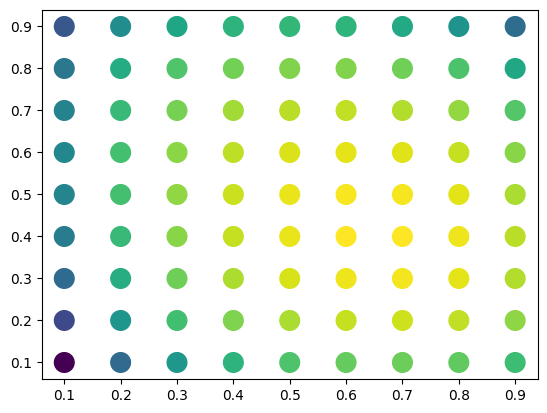

In [36]:
df3 = np.array(p_q_lik3)
plt.scatter(x = df3[:,0], y = df3[:,1], c = df3[:,2], s = 200)
plt.show

In [42]:
max_index = np.argmax(df3, axis = 0)[2]
print("Most likely p is " + str(df3[max_index][0]))
print("Most likely q is " + str(df3[max_index][1]))

Most likely p is 0.7000000000000001
Most likely q is 0.4
